In [409]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint


In [47]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [36]:
data.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Task 1 (LIMIT_BAL)

In [37]:
data_limit = data['LIMIT_BAL']

In [40]:
limi_default_0 = data_limit[data["default"] == 0]
limi_default_1 = data_limit[data['default'] == 1]
print len(limi_default_0)
print len(limi_default_1)

23364
6636


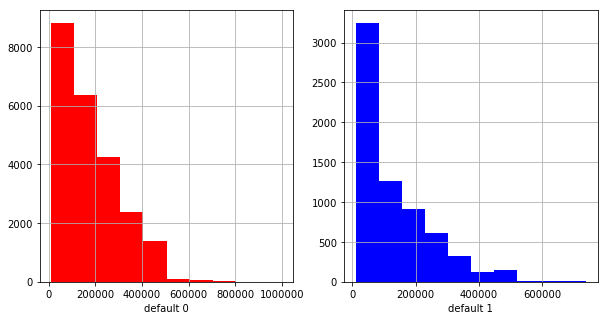

In [90]:
pylab.figure(figsize=(10,5))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(limi_default_0, color = 'r')
pylab.xlabel('default 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(limit_defolt_1, color = 'b')
pylab.xlabel('default 1')

pylab.show()

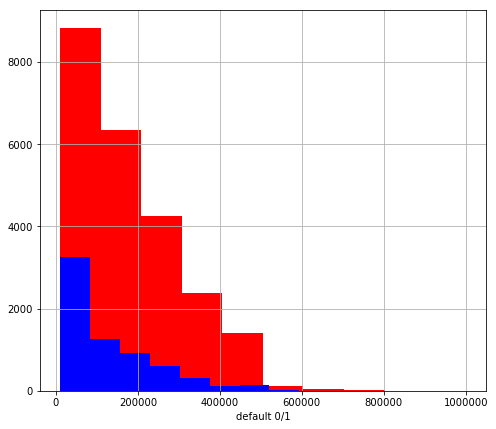

In [95]:
pylab.figure(figsize=(8,7))

pylab.grid()
pylab.hist(limi_default_0, color = 'red')
pylab.hist(limi_default_1, color = 'b')
pylab.xlabel('default 0/1')

pylab.show()

По графикам видно, что люди не отдающие кредит, берут суммы меньше

$H_0: $ медианные значения равны

$H_1: $ медианные значения не равны

In [41]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [100]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [106]:
np.random.seed(0)

limi_default_0_median_scores = map(np.median, get_bootstrap_samples(limi_default_0.values, 1000))
limi_default_1_median_scores = map(np.median, get_bootstrap_samples(limi_default_1.values, 1000))

print "95% confidence interval for the limit bal 0:",  stat_intervals(limi_default_0_median_scores, 0.05)
print "95% confidence interval for the limit bal 1:",  stat_intervals(limi_default_1_median_scores, 0.05)

95% confidence interval for the limit bal 0: [150000. 150000.]
95% confidence interval for the limit bal 1: [80000. 90000.]


интервалы не пересекаются, следовательно, можно отвергнуть нулевую гипотизу о равенстве двух медиан

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [77]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr



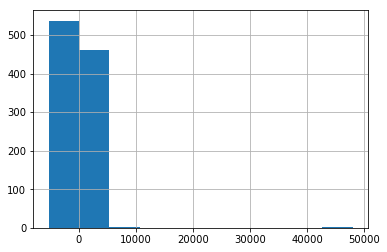

In [190]:
pylab.hist(permutation_zero_dist_ind(limi_default_0, limi_default_1, max_combinations = 1000))
pylab.grid()
pylab.show()

In [79]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [81]:
print "p-value: %f" % permutation_test(limi_default_0, limi_default_1, max_permutations = 10000)

p-value: 0.000020


p-value получилось достаточно низким, нулевая гипотиза отвергается на уровне доверия 0.05

результаты получились практически значимы, слишком большая разница медиан

## Task 2 (SEX)

In [108]:
data.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [120]:
sex_default_0 = data['SEX'][data['default']==0]
sex_default_1 = data['SEX'][data['default']==1]

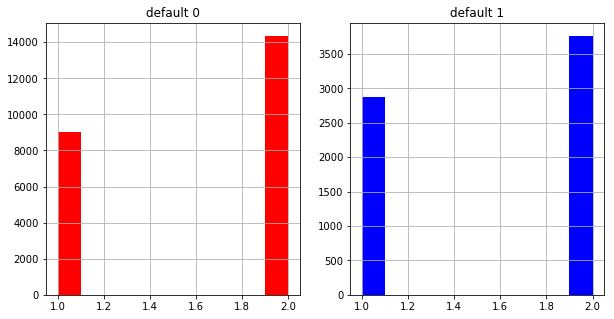

In [125]:
pylab.figure(figsize=(10,5))

pylab.subplot(1, 2, 1)
pylab.hist(sex_default_0, color = 'r')
pylab.grid()
pylab.title('default 0')

pylab.subplot(1, 2, 2)
pylab.hist(sex_default_1, color = 'b')
pylab.grid()
pylab.title('default 1')

pylab.show()

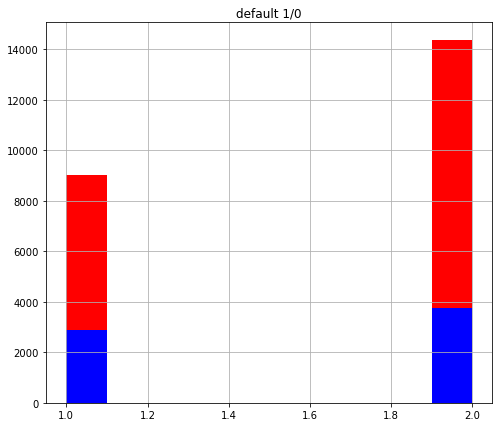

In [139]:
pylab.figure(figsize = (8, 7))

pylab.hist(sex_default_0, color = 'r')
pylab.hist(sex_default_1, color = 'b')
pylab.grid()
pylab.title('default 1/0')
pylab.show()

по графику можно заметить, что женщины чаще оказываются в должниках

In [188]:
male_default_0 = (sex_default_0[sex_default_0 == 1]) ## мужчины вернувшие кредит
male_default_1 = (sex_default_1[sex_default_1 == 1]) ## мужчины не вернувшие кредит

In [189]:
interval_male_0 = (proportion_confint(len(male_default_0), sex_default_0.shape[0]))
interval_male_1 = (proportion_confint(len(male_default_1), sex_default_1.shape[0]))

print '95% confidence interval for the male default 0 {}'.format(interval_male_0)
print '95% confidence interval for the male default 1 {}'.format(interval_male_1)

95% confidence interval for the male default 0 (0.37960806572767264, 0.3920919856333957)
95% confidence interval for the male default 1 (0.4210202357094044, 0.44486282637618935)


Интервалы не пересекаются, следовательно, гендерный состав группы людей вернувших и не вернувших кредит отличается

$H_0: $ гендерные группы не отличаются

$H_1: $ гендерные группы отличаются

In [191]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [203]:
print "p-value: %.20f" % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_default_0-2), np.abs(sex_default_1-2)))

p-value: 0.00000000000447286652


p-value получилось очень маленьким, значит уверенно отвергаем $H_0$

Результаты практически значимы

## Task 3 (EDUCATION)


EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных)

In [210]:
ed = data['EDUCATION']
ed_def_0 = data['EDUCATION'][data['default']==0]
ed_def_1 = data['EDUCATION'][data['default']==1]

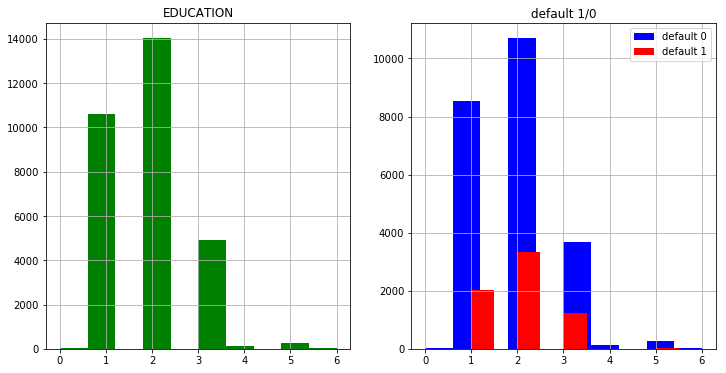

In [219]:
pylab.figure(figsize=(12, 6))
pylab.subplot(1, 2, 1)
pylab.hist(ed, color='green')
pylab.grid()
pylab.title('EDUCATION')

pylab.subplot(1, 2, 2)
pylab.hist(ed_def_0, color='blue', label='default 0')
pylab.hist(ed_def_1, color='red', label='default 1')
pylab.grid()
pylab.title('default 1/0')
pylab.legend()

pylab.show()

По графику трудно сделать выводы, распределения очень похожи

In [322]:
ed_number_0 = [np.sum(ed_def_0.values == i) for i in range(7)]
ed_number_1 = [np.sum(ed_def_1.values == i) for i in range(7)]
ed_number_0_1 = zip(ed_number_0, ed_number_1)

$H_0$: Рассматриваемая величина имет равномерное распределение

$H_1$: Рассматриваемая величина имеет не равномерное распределение

Пользоваться будем критериям согласия Пирсона хи-квадрат

Кол-во людей вернувших и не вернувших кредит в каждой группе

In [272]:
index = 0
for i, j in ed_number_0_1:
    print 'education: {} default 0/1: {}/{}'.format(index, i, j)
    index += 1

education: 0 default 0/1: 14/0
education: 1 default 0/1: 8549/2036
education: 2 default 0/1: 10700/3330
education: 3 default 0/1: 3680/1237
education: 4 default 0/1: 116/7
education: 5 default 0/1: 262/18
education: 6 default 0/1: 43/8


Среднее занчение доли возвратов для всех групп образования

In [292]:
ed_proportion = [(1 - float(j)/i) for i, j in ed_number_0_1]
ed_proportion_mean = np.mean(ed_proportion)
print 'mean values proportions: {}'.format(ed_proportion_mean)

mean values proportions: 0.828484800508


Возьмем значение 0.828 за ожидаемую вероятность возвращения кредита

In [321]:
for index, i in enumerate(ed_proportion):
    print 'education: {} proportion {}'.format(index, i)

education: 0 proportion 1.0
education: 1 proportion 0.761843490467
education: 2 proportion 0.688785046729
education: 3 proportion 0.663858695652
education: 4 proportion 0.939655172414
education: 5 proportion 0.931297709924
education: 6 proportion 0.813953488372


можем увидеть что хуже все возвращают долги образование со статусом 2 и 3 (бакалавры и выпускники школы), можно сделать вывод о не равномерности распределения

In [309]:
expected = [int(ed_proportion_mean * i) for i in ed_number_0]

In [310]:
real_expected = zip(ed_number_0, expected)

составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки будут разность между наблюдаемым и ожидаемым количеством человек, которые вернули кредит

In [312]:
index_0 = 0
for i, j in real_expected:
    print 'education: {} expected: {} real: {} delta: {}'.format(index_0, j, i, j-i)
    index_0 += 1

education: 0 expected: 11 real: 14 delta: -3
education: 1 expected: 7082 real: 8549 delta: -1467
education: 2 expected: 8864 real: 10700 delta: -1836
education: 3 expected: 3048 real: 3680 delta: -632
education: 4 expected: 96 real: 116 delta: -20
education: 5 expected: 217 real: 262 delta: -45
education: 6 expected: 35 real: 43 delta: -8


In [318]:
stats.chisquare(ed_number_0, expected, ddof = 1)

Power_divergenceResult(statistic=831.3619809304885, pvalue=1.8971858556049717e-177)

уверенно отвергаем гипотизу $H_0$ 

Практическая значимость очень серьезная, потому что доли возврата сильно отличимы

## Task4 (MARRIAGE)

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [328]:
marr = data['MARRIAGE']
marr_def_0 = data['MARRIAGE'][data['default']==0]
marr_def_1 = data['MARRIAGE'][data['default']==1]

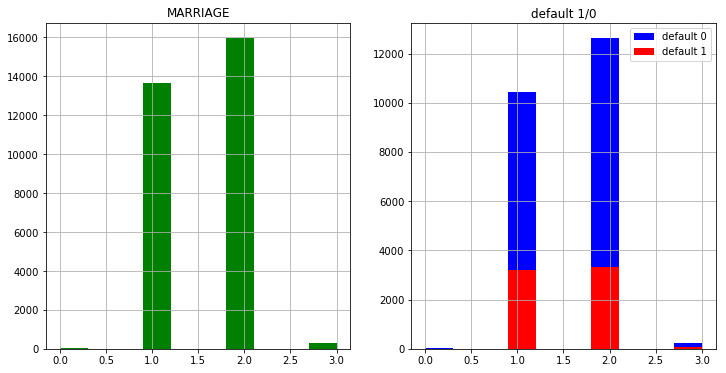

In [331]:
pylab.figure(figsize=(12, 6))

pylab.subplot(1, 2, 1)
pylab.hist(marr, color='g')
pylab.grid()
pylab.title('MARRIAGE')

pylab.subplot(1, 2, 2)
pylab.hist(marr_def_0, color='b', label='default 0')
pylab.hist(marr_def_1, color='r', label='default 1')
pylab.grid()
pylab.title('default 1/0')
pylab.legend()

pylab.show()

На глаз отличние между возвратами холостых и замужем/женат маленькая

In [373]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [347]:
conf_table = np.empty( (len(marr.value_counts()), 2) )
conf_table

array([[  0.   , -11.6  ],
       [  0.   ,  -1.6  ],
       [ 44.875,  -1.6  ],
       [ 44.875, -11.6  ]])

In [352]:
tb = np.zeros((4, 2))

In [385]:
for i in range(4):
    tb[i, 0] = len(marr_def_0[marr_def_0 == i])
    tb[i, 1] = len(marr_def_1[marr_def_1 == i])

In [386]:
cramers_stat(tb)

0.034478203662766466

Коэффициент Крамера близок к нулю, делаем вывод о незначимости MARRIAGE для заемщика

## Task 5 (AGE)

In [389]:
age_def_0 = data['AGE'][data['default']==0]
age_def_1 = data['AGE'][data['default']==1]

(array([5.127e+03, 8.261e+03, 6.514e+03, 4.812e+03, 2.606e+03, 1.836e+03,
        6.280e+02, 1.710e+02, 4.000e+01, 5.000e+00]),
 array([21. , 26.8, 32.6, 38.4, 44.2, 50. , 55.8, 61.6, 67.4, 73.2, 79. ]),
 <a list of 10 Patch objects>)

(array([3.842e+03, 6.621e+03, 5.165e+03, 3.744e+03, 1.990e+03, 1.382e+03,
        4.560e+02, 1.300e+02, 3.000e+01, 4.000e+00]),
 array([21. , 26.8, 32.6, 38.4, 44.2, 50. , 55.8, 61.6, 67.4, 73.2, 79. ]),
 <a list of 10 Patch objects>)

(array([1285., 1415., 1380.,  950.,  705.,  564.,  220.,   89.,   21.,
           7.]),
 array([21. , 26.4, 31.8, 37.2, 42.6, 48. , 53.4, 58.8, 64.2, 69.6, 75. ]),
 <a list of 10 Patch objects>)

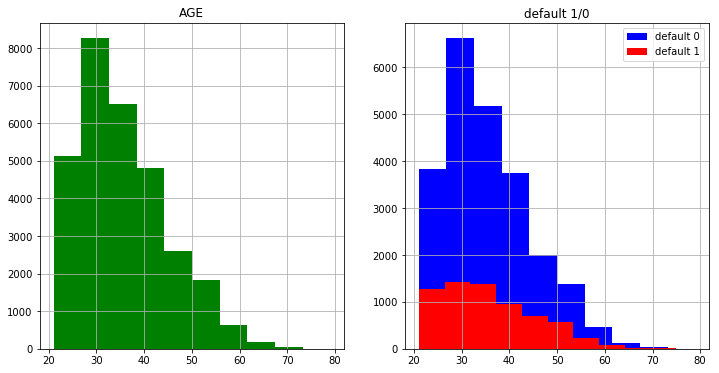

In [410]:
pylab.figure(figsize=(12, 6))

pylab.subplot(1, 2, 1)
pylab.hist(data['AGE'], color='g')
pylab.grid()
pylab.title('AGE')

pylab.subplot(1, 2, 2)
pylab.hist(age_def_0, color='b', label='default 0')
pylab.hist(age_def_1, color='r', label='default 1')
pylab.grid()
pylab.title('default 1/0')
pylab.legend()

pylab.show()

$H_0: $ медианные значения равны

$H_1: $ медианные значения не равны

Используем бутстреп

In [407]:
np.random.seed(0)

age_def_0_median_scores = map(np.median, get_bootstrap_samples(age_def_0.values, 1000))
age_def_1_median_scores = map(np.median, get_bootstrap_samples(age_def_1.values, 1000))

print "95% confidence interval for the limit bal 0:",  stat_intervals(age_def_0_median_scores, 0.05)
print "95% confidence interval for the limit bal 1:",  stat_intervals(age_def_1_median_scores, 0.05)

 95% confidence interval for the limit bal 0: [34. 34.]
95% confidence interval for the limit bal 1: [34. 35.]


интервалы пересекаются, следовательно не отвергаем гипотизу о равенстве двух медиан

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [408]:
print "p-value: %f" % permutation_test(age_def_0, age_def_1, max_permutations = 10000)

p-value: 0.017700


p-value получился низким, отвергаем гипотизу о одинаковости распределений двух выборок с уровнем значимости 0.05

результат практически занчим